In [ ]:
#
# Copyright 2021- IBM Inc. All rights reserved
# SPDX-License-Identifier: Apache2.0
#

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import math
import os
import joblib
import pydot
print(tf.__version__)

2.11.0


In [2]:
seq_length = 7 # Six past transactions followed by current transaction

# Process database

In [5]:
tdf = pd.read_csv('Data/card_transaction.v1.csv')
tdf['Merchant Name'] = tdf['Merchant Name'].astype(str)
tdf.sort_values(by=['User','Card'], inplace=True)
tdf.reset_index(inplace=True, drop=True)
print (tdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   object 
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(6), object(8)
memory usage: 2.7+ GB
None


In [6]:
# Get first of each User-Card combination
first = tdf[['User','Card']].drop_duplicates()
f = np.array(first.index)

In [7]:
# Drop the first N transactions
drop_list = np.concatenate([np.arange(x,x + seq_length - 1) for x in f])
index_list = np.setdiff1d(tdf.index.values,drop_list)

In [8]:
# Split into 0.5 train, 0.3 validate, 0.2 test
tot_length = index_list.shape[0]
train_length = tot_length // 2
validate_length = (tot_length - train_length) * 3 // 5
test_length = tot_length - train_length - validate_length
print (tot_length,train_length,validate_length, test_length)

24350099 12175049 7305030 4870020


In [9]:
# Generate list of indices for train, validate, test
np.random.seed(1111)
train_indices = np.random.choice(index_list, train_length, replace=False)
tv_list = np.setdiff1d(index_list, train_indices)
validate_indices = np.random.choice(tv_list, validate_length, replace=False)
test_indices = np.setdiff1d(tv_list, validate_indices)
print (train_indices, validate_indices, test_indices)

[ 9802207 14106565  3424650 ...   986295    31770 22457273] [11386714 20819702 13959897 ...  6750280  4076771 23370874] [       9       14       23 ... 24386880 24386886 24386894]


# Uncomment the last line to generate a test sample: database + test indices

In [10]:
def create_test_sample(df, indices):
    print(indices)
    rows = indices.shape[0]
    index_array = np.zeros((rows, seq_length), dtype=int)
    for i in range(seq_length):
        index_array[:,i] = indices + 1 - seq_length + i
    uniques = np.unique(index_array.flatten())
    df.loc[uniques].to_csv('test_220_100k.csv',index_label='Index')
    np.savetxt('test_220_100k.indices',indices.astype(int),fmt='%d')

create_test_sample(tdf, validate_indices[:100000]) # Uncomment this line to generate a test sample                    

[11386714 20819702 13959897 ...  7418203 13532884  5122780]


# Define custom mapping functions

In [41]:
def timeEncoder(X):
    X_hm = X['Time'].str.split(':', expand=True)
    d = pd.to_datetime(dict(year=X['Year'],month=X['Month'],day=X['Day'],hour=X_hm[0],minute=X_hm[1]))
    d = d.values.astype(int)
    print(d.dtype)
    d = d.astype(int)
    return pd.DataFrame(d)

def amtEncoder(X):
    amt = X.apply(lambda x: x[1:]).astype(float).map(lambda amt: max(1,amt)).map(math.log)
    return pd.DataFrame(amt)

def decimalEncoder(X,length=5):
    dnew = pd.DataFrame()
    for i in range(length):
        dnew[i] = np.mod(X,10) 
        X = np.floor_divide(X,10)
    return dnew

def fraudEncoder(X):
    return np.where(X == 'Yes', 1, 0).astype(int)

# Fit the whole data using DataFrameMapper and pickle the mapper

In [9]:
save_dir = 'saved_models/P/ccf_220_keras_gru_static/1'

In [43]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

mapper = DataFrameMapper([
                          ('Is Fraud?', FunctionTransformer(fraudEncoder)),
                          (['Merchant State'], [SimpleImputer(strategy='constant'), FunctionTransformer(np.ravel),
                                               LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          (['Zip'], [SimpleImputer(strategy='constant'), FunctionTransformer(np.ravel),
                                     FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          ('Merchant Name', [LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          ('Merchant City', [LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          ('MCC', [LabelEncoder(), FunctionTransformer(decimalEncoder), OneHotEncoder()]),
                          (['Use Chip'], [SimpleImputer(strategy='constant'), LabelBinarizer()]),
                          (['Errors?'], [SimpleImputer(strategy='constant'), LabelBinarizer()]),
                          (['Year','Month','Day','Time'], [FunctionTransformer(timeEncoder), MinMaxScaler()]),
                          ('Amount', [FunctionTransformer(amtEncoder), MinMaxScaler()])
                         ], input_df=True, df_out=True)
mapper.fit(tdf)

joblib.dump(mapper, open('fitted_mapper.pkl','wb'))

int32


In [3]:
mapper = joblib.load(open('fitted_mapper.pkl','rb'))

# Do a transform on one row to get number of mapped features (including label)

In [17]:
mapped_sample = mapper.transform(tdf[:100])
mapped_size = mapped_sample.shape[-1]
print(mapped_size)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_fea

int32
221


# Generator for training batches

In [4]:
def gen_training_batch(df, mapper, index_list, batch_size):
    np.random.seed(98765)
    train_df = df.loc[index_list]
    non_fraud_indices = train_df[train_df['Is Fraud?'] == 'No'].index.values
    fraud_indices = train_df[train_df['Is Fraud?'] == 'Yes'].index.values
    fsize = fraud_indices.shape[0]
    while True:
        indices = np.concatenate((fraud_indices,np.random.choice(non_fraud_indices,fsize,replace=False)))
        np.random.shuffle(indices)
        rows = indices.shape[0]
        index_array = np.zeros((rows, seq_length), dtype=np.int)
        for i in range(seq_length):
            index_array[:,i] = indices + 1 - seq_length + i
        full_df = mapper.transform(df.loc[index_array.flatten()])
        target_buffer = full_df['Is Fraud?'].to_numpy().reshape(rows, seq_length, 1)
        data_buffer = full_df.drop(['Is Fraud?'],axis=1).to_numpy().reshape(rows, seq_length, -1)

        batch_ptr = 0
        while (batch_ptr + batch_size) <= rows:
            data = data_buffer[batch_ptr:batch_ptr+batch_size]
            targets = target_buffer[batch_ptr:batch_ptr+batch_size]
            batch_ptr += batch_size
            data_t = np.transpose(data, axes=(1,0,2))
            targets_t = np.transpose(targets, axes=(1,0,2))
            yield data_t,targets_t

# Utilities 

In [5]:
def print_trainable_parameters():
    total = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        parameters = 1
        for dim in shape:
            parameters *= dim
        total += parameters
        print (variable, shape, parameters)
    print(total)

def f1(conf):
    precision = float(conf[1][1]) / (conf[1][1]+conf[0][1])
    recall = float(conf[1][1]) / (conf[1][1]+conf[1][0])
    return 2 * precision * recall / (precision + recall)

class TP(tf.keras.metrics.TruePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)

class FP(tf.keras.metrics.FalsePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)

class FN(tf.keras.metrics.FalseNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)

class TN(tf.keras.metrics.TrueNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true[-1,:,:], y_pred[-1,:,:], sample_weight)


# Graph parameters

In [18]:
units = [200,200]
input_size = mapped_size - 1
output_size = 1

In [50]:
!pip install graphviz

# Tensorflow graph construction

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (7, 16, 200)              253200    
                                                                 
 gru_7 (GRU)                 (7, 16, 200)              241200    
                                                                 
 dense_3 (Dense)             (7, 16, 1)                201       
                                                                 
Total params: 494,601
Trainable params: 494,601
Non-trainable params: 0
_________________________________________________________________


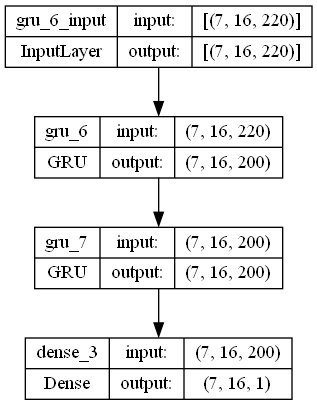

In [28]:
batch_size = 16
tf_input = ([batch_size, input_size])

gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units[0], input_shape=tf_input, batch_size=7, time_major=True, return_sequences=True),
    tf.keras.layers.GRU(units[1], return_sequences=True, time_major=True),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])

gru_model.summary()
# from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(gru_model, 'model.png', show_shapes=True)

In [6]:
metrics=['accuracy', 
    TP(name='TP'),
    FP(name='FP'),
    FN(name='FN'),
    TN(name='TN'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.TrueNegatives(name='tn')
   ]

# Compile graph

In [31]:
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# Tensorflow training parameters

In [32]:
steps_per_epoch = 20000
checkpoint_dir = "./checkpoints/ccf_220_keras_gru_static/"
filepath = checkpoint_dir + "iter-{epoch:02d}/model.ckpt"
batch_size = 16

# Tensorflow training

In [23]:
print ("Learning...")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_weights_only=True, verbose=1)
train_generate = gen_training_batch(tdf,mapper,train_indices,batch_size)
gru_model.fit(train_generate, epochs=2, steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[cp_callback])

Learning...


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
Epoch 1/2
 1859/50000 [>.............................] - ETA: 22:16 - loss: 0.1530 - accuracy: 0.9490 - TP: 12768.0000 - FP: 356.0000 - FN: 2103.0000 - TN: 14517.0000 - tp: 40911.0000 - fp: 2889.0000 - fn: 7728.0000 - tn: 156680.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 3717/50000 [=>............................] - ETA: 26:01 - loss: 0.1303 - accuracy: 0.9560 - TP: 26277.0000 - FP: 674.0000 - FN: 3454.0000 - TN: 29067.0000 - tp: 83838.0000 - fp: 4886.0000 - fn: 13417.0000 - tn: 314163.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 5576/50000 [==>...........................] - ETA: 26:38 - loss: 0.1130 - accuracy: 0.9614 - TP: 40328.0000 - FP: 978.0000 - FN: 4281.0000 - TN: 43629.0000 - tp: 128448.0000 - fp: 6666.0000 - fn: 17471.0000 - tn: 471927.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 7435/50000 [===>..........................] - ETA: 26:31 - loss: 0.0996 - accuracy: 0.9656 - TP: 54639.0000 - FP: 1283.0000 - FN: 4838.0000 - TN: 58200.0000 - tp: 174162.0000 - fp: 8245.0000 - fn: 20392.0000 - tn: 629921.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 9295/50000 [====>.........................] - ETA: 25:57 - loss: 0.0887 - accuracy: 0.9692 - TP: 69151.0000 - FP: 1504.0000 - FN: 5205.0000 - TN: 72860.0000 - tp: 220684.0000 - fp: 9487.0000 - fn: 22544.0000 - tn: 788325.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
11154/50000 [=====>........................] - ETA: 24:56 - loss: 0.0798 - accuracy: 0.9722 - TP: 83751.0000 - FP: 1674.0000 - FN: 5477.0000 - TN: 87562.0000 - tp: 267695.0000 - fp: 10573.0000 - fn: 24188.0000 - tn: 946792.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
13012/50000 [======>.......................] - ETA: 23:51 - loss: 0.0726 - accuracy: 0.9746 - TP: 98429.0000 - FP: 1825.0000 - FN: 5664.0000 - TN: 102274.0000 - tp: 314997.0000 - fp: 11476.0000 - fn: 25530.0000 - tn: 1105341.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
14871/50000 [=======>......................] - ETA: 22:47 - loss: 0.0666 - accuracy: 0.9766 - TP: 113157.0000 - FP: 1950.0000 - FN: 5812.0000 - TN: 117017.0000 - tp: 362571.0000 - fp: 12256.0000 - fn: 26637.0000 - tn: 1264088.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
16731/50000 [=========>....................] - ETA: 21:37 - loss: 0.0616 - accuracy: 0.9784 - TP: 127923.0000 - FP: 2054.0000 - FN: 5926.0000 - TN: 131793.0000 - tp: 410320.0000 - fp: 12960.0000 - fn: 27579.0000 - tn: 1423013.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
18589/50000 [==========>...................] - ETA: 20:27 - loss: 0.0574 - accuracy: 0.9798 - TP: 142702.0000 - FP: 2147.0000 - FN: 6010.0000 - TN: 146565.0000 - tp: 458089.0000 - fp: 13599.0000 - fn: 28443.0000 - tn: 1581837.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
20448/50000 [===========>..................] - ETA: 19:19 - loss: 0.0538 - accuracy: 0.9810 - TP: 157485.0000 - FP: 2236.0000 - FN: 6098.0000 - TN: 161349.0000 - tp: 505954.0000 - fp: 14194.0000 - fn: 29227.0000 - tn: 1740801.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
22307/50000 [============>.................] - ETA: 18:11 - loss: 0.0507 - accuracy: 0.9821 - TP: 172271.0000 - FP: 2331.0000 - FN: 6183.0000 - TN: 176127.0000 - tp: 553893.0000 - fp: 14734.0000 - fn: 29969.0000 - tn: 1899788.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
24167/50000 [=============>................] - ETA: 16:59 - loss: 0.0480 - accuracy: 0.9831 - TP: 187069.0000 - FP: 2410.0000 - FN: 6267.0000 - TN: 190926.0000 - tp: 601974.0000 - fp: 15240.0000 - fn: 30599.0000 - tn: 2058891.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
26025/50000 [==============>...............] - ETA: 15:48 - loss: 0.0456 - accuracy: 0.9839 - TP: 201873.0000 - FP: 2483.0000 - FN: 6325.0000 - TN: 205719.0000 - tp: 650020.0000 - fp: 15719.0000 - fn: 31189.0000 - tn: 2217872.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
27885/50000 [===============>..............] - ETA: 14:36 - loss: 0.0436 - accuracy: 0.9846 - TP: 216692.0000 - FP: 2550.0000 - FN: 6391.0000 - TN: 220527.0000 - tp: 698102.0000 - fp: 16229.0000 - fn: 31804.0000 - tn: 2376985.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
29744/50000 [================>.............] - ETA: 13:28 - loss: 0.0417 - accuracy: 0.9853 - TP: 231511.0000 - FP: 2609.0000 - FN: 6442.0000 - TN: 235342.0000 - tp: 746205.0000 - fp: 16654.0000 - fn: 32360.0000 - tn: 2536109.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
31603/50000 [=================>............] - ETA: 12:17 - loss: 0.0399 - accuracy: 0.9859 - TP: 246343.0000 - FP: 2657.0000 - FN: 6479.0000 - TN: 250169.0000 - tp: 794345.0000 - fp: 17037.0000 - fn: 32871.0000 - tn: 2695283.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
33462/50000 [===================>..........] - ETA: 11:05 - loss: 0.0384 - accuracy: 0.9864 - TP: 261151.0000 - FP: 2705.0000 - FN: 6541.0000 - TN: 264995.0000 - tp: 842465.0000 - fp: 17448.0000 - fn: 33402.0000 - tn: 2854429.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
35321/50000 [====================>.........] - ETA: 9:53 - loss: 0.0370 - accuracy: 0.9869 - TP: 275991.0000 - FP: 2750.0000 - FN: 6576.0000 - TN: 279819.0000 - tp: 890627.0000 - fp: 17825.0000 - fn: 33907.0000 - tn: 3013593.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
37179/50000 [=====================>........] - ETA: 8:40 - loss: 0.0357 - accuracy: 0.9874 - TP: 290814.0000 - FP: 2803.0000 - FN: 6618.0000 - TN: 294629.0000 - tp: 938746.0000 - fp: 18206.0000 - fn: 34387.0000 - tn: 3172709.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
39039/50000 [======================>.......] - ETA: 7:27 - loss: 0.0346 - accuracy: 0.9878 - TP: 305658.0000 - FP: 2859.0000 - FN: 6658.0000 - TN: 309449.0000 - tp: 986983.0000 - fp: 18604.0000 - fn: 34865.0000 - tn: 3331916.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
40897/50000 [=======================>......] - ETA: 6:12 - loss: 0.0335 - accuracy: 0.9881 - TP: 320475.0000 - FP: 2907.0000 - FN: 6704.0000 - TN: 324266.0000 - tp: 1035160.0000 - fp: 18938.0000 - fn: 35343.0000 - tn: 3491023.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
42756/50000 [========================>.....] - ETA: 4:57 - loss: 0.0325 - accuracy: 0.9885 - TP: 335301.0000 - FP: 2955.0000 - FN: 6749.0000 - TN: 339091.0000 - tp: 1083355.0000 - fp: 19297.0000 - fn: 35799.0000 - tn: 3650221.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
44616/50000 [=========================>....] - ETA: 3:41 - loss: 0.0316 - accuracy: 0.9888 - TP: 350136.0000 - FP: 2996.0000 - FN: 6794.0000 - TN: 353930.0000 - tp: 1131616.0000 - fp: 19634.0000 - fn: 36231.0000 - tn: 3809511.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
46474/50000 [==========================>...] - ETA: 2:25 - loss: 0.0307 - accuracy: 0.9891 - TP: 364957.0000 - FP: 3039.0000 - FN: 6834.0000 - TN: 368754.0000 - tp: 1179793.0000 - fp: 19938.0000 - fn: 36689.0000 - tn: 3968668.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
48334/50000 [============================>.] - ETA: 1:09 - loss: 0.0299 - accuracy: 0.9894 - TP: 379797.0000 - FP: 3077.0000 - FN: 6878.0000 - TN: 383592.0000 - tp: 1228085.0000 - fp: 20288.0000 - fn: 37126.0000 - tn: 4127909.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
49999/50000 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9896 - TP: 393083.0000 - FP: 3110.0000 - FN: 6908.0000 - TN: 396883.0000 - tp: 1271241.0000 - fp: 20568.0000 - fn: 37504.0000 - tn: 4270575.0000
Epoch 1: saving model to ./checkpoints/ccf_220_keras_gru_static/iter-01\model.ckpt
50000/50000 [==============================] - 2088s 42ms/step - loss: 0.0293 - accuracy: 0.9896 - TP: 393089.0000 - FP: 3110.0000 - FN: 6908.0000 - TN: 396893.0000 - tp: 1271261.0000 - fp: 20568.0000 - fn: 37504.0000 - tn: 4270667.0000
Epoch 2/2
  193/50000 [..............................] - ETA: 24:30 - loss: 0.0110 - accuracy: 0.9960 - TP: 1545.0000 - FP: 6.0000 - FN: 6.0000 - TN: 1531.0000 - tp: 5086.0000 - fp: 39.0000 - fn: 48.0000 - tn: 16443.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 2052/50000 [>.............................] - ETA: 33:44 - loss: 0.0100 - accuracy: 0.9964 - TP: 16375.0000 - FP: 52.0000 - FN: 48.0000 - TN: 16357.0000 - tp: 53342.0000 - fp: 353.0000 - fn: 465.0000 - tn: 175664.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 3911/50000 [=>............................] - ETA: 33:16 - loss: 0.0097 - accuracy: 0.9966 - TP: 31207.0000 - FP: 93.0000 - FN: 90.0000 - TN: 31186.0000 - tp: 101626.0000 - fp: 628.0000 - fn: 866.0000 - tn: 334912.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 5769/50000 [==>...........................] - ETA: 32:05 - loss: 0.0094 - accuracy: 0.9966 - TP: 46044.0000 - FP: 133.0000 - FN: 120.0000 - TN: 46007.0000 - tp: 149848.0000 - fp: 894.0000 - fn: 1284.0000 - tn: 494102.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 7628/50000 [===>..........................] - ETA: 30:47 - loss: 0.0095 - accuracy: 0.9966 - TP: 60879.0000 - FP: 169.0000 - FN: 157.0000 - TN: 60843.0000 - tp: 198086.0000 - fp: 1184.0000 - fn: 1720.0000 - tn: 653346.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
 9487/50000 [====>.........................] - ETA: 30:13 - loss: 0.0094 - accuracy: 0.9967 - TP: 75737.0000 - FP: 200.0000 - FN: 174.0000 - TN: 75681.0000 - tp: 246364.0000 - fp: 1456.0000 - fn: 2102.0000 - tn: 812622.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
11346/50000 [=====>........................] - ETA: 28:49 - loss: 0.0094 - accuracy: 0.9967 - TP: 90579.0000 - FP: 234.0000 - FN: 207.0000 - TN: 90516.0000 - tp: 294639.0000 - fp: 1725.0000 - fn: 2520.0000 - tn: 971868.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
13205/50000 [======>.......................] - ETA: 27:35 - loss: 0.0093 - accuracy: 0.9967 - TP: 105416.0000 - FP: 271.0000 - FN: 244.0000 - TN: 105349.0000 - tp: 342883.0000 - fp: 1994.0000 - fn: 2939.0000 - tn: 1131144.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
15064/50000 [========>.....................] - ETA: 26:24 - loss: 0.0092 - accuracy: 0.9967 - TP: 120256.0000 - FP: 300.0000 - FN: 273.0000 - TN: 120195.0000 - tp: 391127.0000 - fp: 2233.0000 - fn: 3318.0000 - tn: 1290490.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
16924/50000 [=========>....................] - ETA: 25:04 - loss: 0.0091 - accuracy: 0.9967 - TP: 135107.0000 - FP: 339.0000 - FN: 303.0000 - TN: 135035.0000 - tp: 439429.0000 - fp: 2505.0000 - fn: 3715.0000 - tn: 1449839.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
18782/50000 [==========>...................] - ETA: 23:48 - loss: 0.0090 - accuracy: 0.9968 - TP: 149945.0000 - FP: 370.0000 - FN: 328.0000 - TN: 149869.0000 - tp: 487698.0000 - fp: 2731.0000 - fn: 4081.0000 - tn: 1609074.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
20642/50000 [===========>..................] - ETA: 22:28 - loss: 0.0090 - accuracy: 0.9968 - TP: 164796.0000 - FP: 391.0000 - FN: 357.0000 - TN: 164728.0000 - tp: 535981.0000 - fp: 2989.0000 - fn: 4478.0000 - tn: 1768456.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
22501/50000 [============>.................] - ETA: 21:04 - loss: 0.0091 - accuracy: 0.9968 - TP: 179630.0000 - FP: 434.0000 - FN: 395.0000 - TN: 179557.0000 - tp: 584259.0000 - fp: 3265.0000 - fn: 4886.0000 - tn: 1927702.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
24360/50000 [=============>................] - ETA: 19:40 - loss: 0.0090 - accuracy: 0.9968 - TP: 194481.0000 - FP: 457.0000 - FN: 413.0000 - TN: 194409.0000 - tp: 632552.0000 - fp: 3494.0000 - fn: 5252.0000 - tn: 2087022.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
26219/50000 [==============>...............] - ETA: 18:20 - loss: 0.0089 - accuracy: 0.9968 - TP: 209332.0000 - FP: 477.0000 - FN: 433.0000 - TN: 209262.0000 - tp: 680889.0000 - fp: 3712.0000 - fn: 5600.0000 - tn: 2246327.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
28077/50000 [===============>..............] - ETA: 16:54 - loss: 0.0090 - accuracy: 0.9968 - TP: 224169.0000 - FP: 517.0000 - FN: 457.0000 - TN: 224089.0000 - tp: 729147.0000 - fp: 3975.0000 - fn: 5991.0000 - tn: 2405511.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
29936/50000 [================>.............] - ETA: 15:30 - loss: 0.0089 - accuracy: 0.9968 - TP: 239023.0000 - FP: 545.0000 - FN: 476.0000 - TN: 238932.0000 - tp: 777448.0000 - fp: 4245.0000 - fn: 6355.0000 - tn: 2564784.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
31795/50000 [==================>...........] - ETA: 14:07 - loss: 0.0088 - accuracy: 0.9969 - TP: 253870.0000 - FP: 575.0000 - FN: 503.0000 - TN: 253772.0000 - tp: 825784.0000 - fp: 4468.0000 - fn: 6706.0000 - tn: 2724082.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
33654/50000 [===================>..........] - ETA: 12:43 - loss: 0.0088 - accuracy: 0.9969 - TP: 268721.0000 - FP: 606.0000 - FN: 525.0000 - TN: 268612.0000 - tp: 874104.0000 - fp: 4705.0000 - fn: 7045.0000 - tn: 2883394.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
35514/50000 [====================>.........] - ETA: 11:18 - loss: 0.0087 - accuracy: 0.9969 - TP: 283573.0000 - FP: 634.0000 - FN: 552.0000 - TN: 283465.0000 - tp: 922474.0000 - fp: 4918.0000 - fn: 7417.0000 - tn: 3042759.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
37373/50000 [=====================>........] - ETA: 9:53 - loss: 0.0087 - accuracy: 0.9969 - TP: 298417.0000 - FP: 659.0000 - FN: 576.0000 - TN: 298316.0000 - tp: 970764.0000 - fp: 5159.0000 - fn: 7771.0000 - tn: 3202082.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
39232/50000 [======================>.......] - ETA: 8:26 - loss: 0.0086 - accuracy: 0.9969 - TP: 313270.0000 - FP: 692.0000 - FN: 596.0000 - TN: 313154.0000 - tp: 1019074.0000 - fp: 5396.0000 - fn: 8114.0000 - tn: 3361400.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
41091/50000 [=======================>......] - ETA: 7:00 - loss: 0.0086 - accuracy: 0.9969 - TP: 328117.0000 - FP: 713.0000 - FN: 621.0000 - TN: 328005.0000 - tp: 1067389.0000 - fp: 5631.0000 - fn: 8468.0000 - tn: 3520704.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
42950/50000 [========================>.....] - ETA: 5:34 - loss: 0.0085 - accuracy: 0.9970 - TP: 342962.0000 - FP: 736.0000 - FN: 645.0000 - TN: 342857.0000 - tp: 1115682.0000 - fp: 5848.0000 - fn: 8796.0000 - tn: 3680074.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
44809/50000 [=========================>....] - ETA: 4:06 - loss: 0.0085 - accuracy: 0.9970 - TP: 357805.0000 - FP: 772.0000 - FN: 672.0000 - TN: 357695.0000 - tp: 1163964.0000 - fp: 6097.0000 - fn: 9167.0000 - tn: 3839380.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
46668/50000 [===========================>..] - ETA: 2:38 - loss: 0.0085 - accuracy: 0.9970 - TP: 372649.0000 - FP: 804.0000 - FN: 701.0000 - TN: 372534.0000 - tp: 1212300.0000 - fp: 6310.0000 - fn: 9509.0000 - tn: 3998697.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
48527/50000 [============================>.] - ETA: 1:10 - loss: 0.0084 - accuracy: 0.9970 - TP: 387493.0000 - FP: 826.0000 - FN: 730.0000 - TN: 387383.0000 - tp: 1260606.0000 - fp: 6519.0000 - fn: 9856.0000 - tn: 4158043.0000

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9512\3206109500.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32
50000/50000 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9970 - TP: 399234.0000 - FP: 850.0000 - FN: 746.0000 - TN: 399170.0000 - tp: 1298775.0000 - fp: 6691.0000 - fn: 10120.0000 - tn: 4284414.0000
Epoch 2: saving model to ./checkpoints/ccf_220_keras_gru_static/iter-02\model.ckpt
50000/50000 [==============================] - 2402s 48ms/step - loss: 0.0084 - accuracy: 0.9970 - TP: 399234.0000 - FP: 850.0000 - FN: 746.0000 - TN: 399170.0000 - tp: 1298775.0000 - fp: 6691.0000 - fn: 10120.0000 - tn: 4284414.0000


# Save model from checkpoint

In [24]:
gru_model.save_weights(os.path.join(save_dir,"wts"))
gru_model.save(save_dir)

INFO:tensorflow:Assets written to: saved_models/P/ccf_220_keras_gru_static/1\assets


INFO:tensorflow:Assets written to: saved_models/P/ccf_220_keras_gru_static/1\assets


# Generator for validation/test batches

In [7]:
def gen_test_batch(df, mapper, indices, batch_size):
    rows = indices.shape[0]
    index_array = np.zeros((rows, seq_length), dtype=np.int)
    for i in range(seq_length):
        index_array[:,i] = indices + 1 - seq_length + i
    count = 0
    while (count + batch_size <= rows):        
        full_df = mapper.transform(df.loc[index_array[count:count+batch_size].flatten()])
        data = full_df.drop(['Is Fraud?'],axis=1).to_numpy().reshape(batch_size, seq_length, -1)
        targets = full_df['Is Fraud?'].to_numpy().reshape(batch_size, seq_length, 1)
        count += batch_size
        data_t = np.transpose(data, axes=(1,0,2))
        targets_t = np.transpose(targets, axes=(1,0,2))
        yield data_t, targets_t

# Tensorflow test

In [10]:
batch_size = 2000

input_size=220
output_size=1
units=[200,200]

tf_input = ([batch_size, input_size])

new_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units[0], input_shape=tf_input, batch_size=7, time_major=True, return_sequences=True),
    tf.keras.layers.GRU(units[1], return_sequences=True, time_major=True),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])
new_model.load_weights(os.path.join(save_dir,"wts"))
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
ddf = pd.read_csv('test_220_100k.csv', dtype={"Merchant Name":"str"}, index_col='Index')
indices = np.loadtxt('test_220_100k.indices')

batch_size = 2000

print("\nQuick test")
test_generate = gen_test_batch(ddf,mapper,indices,batch_size)
score = new_model.evaluate(test_generate, verbose=1)
print(score)
# print("\nFull test")
# test_generate = gen_test_batch(tdf,mapper,test_indices,batch_size)
# new_model.evaluate(test_generate, verbose=1)


Quick test


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10104\4121024059.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_array = np.zeros((rows, seq_length), dtype=np.int)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_fea

      1/Unknown - 4s 4s/step - loss: 0.0058 - accuracy: 0.9984 - TP: 1.0000 - FP: 2.0000 - FN: 0.0000e+00 - TN: 1997.0000 - tp: 13.0000 - fp: 23.0000 - fn: 0.0000e+00 - tn: 13964.0000int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      2/Unknown - 6s 2s/step - loss: 0.0065 - accuracy: 0.9981 - TP: 2.0000 - FP: 6.0000 - FN: 0.0000e+00 - TN: 3992.0000 - tp: 36.0000 - fp: 52.0000 - fn: 1.0000 - tn: 27911.0000    

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      3/Unknown - 9s 3s/step - loss: 0.0069 - accuracy: 0.9981 - TP: 8.0000 - FP: 10.0000 - FN: 0.0000e+00 - TN: 5982.0000 - tp: 67.0000 - fp: 78.0000 - fn: 1.0000 - tn: 41854.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      4/Unknown - 11s 2s/step - loss: 0.0063 - accuracy: 0.9983 - TP: 9.0000 - FP: 11.0000 - FN: 0.0000e+00 - TN: 7980.0000 - tp: 72.0000 - fp: 96.0000 - fn: 1.0000 - tn: 55831.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      5/Unknown - 13s 2s/step - loss: 0.0060 - accuracy: 0.9984 - TP: 11.0000 - FP: 12.0000 - FN: 0.0000e+00 - TN: 9977.0000 - tp: 81.0000 - fp: 112.0000 - fn: 1.0000 - tn: 69806.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      6/Unknown - 16s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 14.0000 - FP: 16.0000 - FN: 0.0000e+00 - TN: 11970.0000 - tp: 99.0000 - fp: 129.0000 - fn: 5.0000 - tn: 83767.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      7/Unknown - 18s 2s/step - loss: 0.0066 - accuracy: 0.9983 - TP: 18.0000 - FP: 19.0000 - FN: 0.0000e+00 - TN: 13963.0000 - tp: 119.0000 - fp: 160.0000 - fn: 5.0000 - tn: 97716.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      8/Unknown - 20s 2s/step - loss: 0.0062 - accuracy: 0.9984 - TP: 23.0000 - FP: 22.0000 - FN: 0.0000e+00 - TN: 15955.0000 - tp: 135.0000 - fp: 173.0000 - fn: 6.0000 - tn: 111686.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      9/Unknown - 23s 2s/step - loss: 0.0062 - accuracy: 0.9984 - TP: 27.0000 - FP: 24.0000 - FN: 0.0000e+00 - TN: 17949.0000 - tp: 153.0000 - fp: 189.0000 - fn: 11.0000 - tn: 125647.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     10/Unknown - 25s 2s/step - loss: 0.0062 - accuracy: 0.9984 - TP: 28.0000 - FP: 26.0000 - FN: 0.0000e+00 - TN: 19946.0000 - tp: 158.0000 - fp: 205.0000 - fn: 12.0000 - tn: 139625.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     11/Unknown - 27s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 29.0000 - FP: 28.0000 - FN: 0.0000e+00 - TN: 21943.0000 - tp: 166.0000 - fp: 227.0000 - fn: 12.0000 - tn: 153595.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     12/Unknown - 30s 2s/step - loss: 0.0065 - accuracy: 0.9983 - TP: 29.0000 - FP: 33.0000 - FN: 0.0000e+00 - TN: 23938.0000 - tp: 179.0000 - fp: 263.0000 - fn: 16.0000 - tn: 167542.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     13/Unknown - 32s 2s/step - loss: 0.0067 - accuracy: 0.9983 - TP: 33.0000 - FP: 38.0000 - FN: 0.0000e+00 - TN: 25929.0000 - tp: 200.0000 - fp: 295.0000 - fn: 16.0000 - tn: 181489.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     14/Unknown - 34s 2s/step - loss: 0.0068 - accuracy: 0.9983 - TP: 36.0000 - FP: 42.0000 - FN: 1.0000 - TN: 27921.0000 - tp: 212.0000 - fp: 316.0000 - fn: 18.0000 - tn: 195454.0000    

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     15/Unknown - 36s 2s/step - loss: 0.0067 - accuracy: 0.9983 - TP: 40.0000 - FP: 47.0000 - FN: 1.0000 - TN: 29912.0000 - tp: 232.0000 - fp: 336.0000 - fn: 20.0000 - tn: 209412.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     16/Unknown - 38s 2s/step - loss: 0.0066 - accuracy: 0.9983 - TP: 42.0000 - FP: 48.0000 - FN: 1.0000 - TN: 31909.0000 - tp: 237.0000 - fp: 358.0000 - fn: 20.0000 - tn: 223385.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     17/Unknown - 41s 2s/step - loss: 0.0065 - accuracy: 0.9983 - TP: 44.0000 - FP: 50.0000 - FN: 1.0000 - TN: 33905.0000 - tp: 256.0000 - fp: 372.0000 - fn: 24.0000 - tn: 237348.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     18/Unknown - 44s 2s/step - loss: 0.0065 - accuracy: 0.9984 - TP: 47.0000 - FP: 56.0000 - FN: 1.0000 - TN: 35896.0000 - tp: 270.0000 - fp: 389.0000 - fn: 25.0000 - tn: 251316.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     19/Unknown - 46s 2s/step - loss: 0.0064 - accuracy: 0.9984 - TP: 48.0000 - FP: 58.0000 - FN: 1.0000 - TN: 37893.0000 - tp: 280.0000 - fp: 407.0000 - fn: 25.0000 - tn: 265288.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     20/Unknown - 48s 2s/step - loss: 0.0062 - accuracy: 0.9984 - TP: 51.0000 - FP: 58.0000 - FN: 1.0000 - TN: 39890.0000 - tp: 292.0000 - fp: 422.0000 - fn: 25.0000 - tn: 279261.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     21/Unknown - 51s 2s/step - loss: 0.0062 - accuracy: 0.9984 - TP: 52.0000 - FP: 62.0000 - FN: 1.0000 - TN: 41885.0000 - tp: 302.0000 - fp: 444.0000 - fn: 26.0000 - tn: 293228.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     22/Unknown - 54s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 55.0000 - FP: 68.0000 - FN: 1.0000 - TN: 43876.0000 - tp: 315.0000 - fp: 462.0000 - fn: 27.0000 - tn: 307196.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     23/Unknown - 56s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 57.0000 - FP: 72.0000 - FN: 1.0000 - TN: 45870.0000 - tp: 338.0000 - fp: 483.0000 - fn: 29.0000 - tn: 321150.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     24/Unknown - 58s 2s/step - loss: 0.0062 - accuracy: 0.9984 - TP: 59.0000 - FP: 74.0000 - FN: 1.0000 - TN: 47866.0000 - tp: 341.0000 - fp: 504.0000 - fn: 29.0000 - tn: 335126.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     25/Unknown - 60s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 61.0000 - FP: 76.0000 - FN: 1.0000 - TN: 49862.0000 - tp: 361.0000 - fp: 518.0000 - fn: 30.0000 - tn: 349091.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     26/Unknown - 63s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 62.0000 - FP: 82.0000 - FN: 1.0000 - TN: 51855.0000 - tp: 366.0000 - fp: 541.0000 - fn: 31.0000 - tn: 363062.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     27/Unknown - 66s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 65.0000 - FP: 87.0000 - FN: 1.0000 - TN: 53847.0000 - tp: 382.0000 - fp: 558.0000 - fn: 34.0000 - tn: 377026.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     28/Unknown - 68s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 65.0000 - FP: 88.0000 - FN: 1.0000 - TN: 55846.0000 - tp: 385.0000 - fp: 578.0000 - fn: 34.0000 - tn: 391003.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     29/Unknown - 71s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 67.0000 - FP: 89.0000 - FN: 2.0000 - TN: 57842.0000 - tp: 395.0000 - fp: 592.0000 - fn: 35.0000 - tn: 404978.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     30/Unknown - 73s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 69.0000 - FP: 90.0000 - FN: 2.0000 - TN: 59839.0000 - tp: 407.0000 - fp: 607.0000 - fn: 35.0000 - tn: 418951.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     31/Unknown - 75s 2s/step - loss: 0.0059 - accuracy: 0.9985 - TP: 72.0000 - FP: 93.0000 - FN: 2.0000 - TN: 61833.0000 - tp: 421.0000 - fp: 630.0000 - fn: 38.0000 - tn: 432911.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     32/Unknown - 78s 2s/step - loss: 0.0059 - accuracy: 0.9985 - TP: 74.0000 - FP: 96.0000 - FN: 2.0000 - TN: 63828.0000 - tp: 443.0000 - fp: 649.0000 - fn: 39.0000 - tn: 446869.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     33/Unknown - 80s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 75.0000 - FP: 101.0000 - FN: 2.0000 - TN: 65822.0000 - tp: 450.0000 - fp: 688.0000 - fn: 41.0000 - tn: 460821.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     34/Unknown - 82s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 79.0000 - FP: 105.0000 - FN: 2.0000 - TN: 67814.0000 - tp: 464.0000 - fp: 708.0000 - fn: 41.0000 - tn: 474787.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     35/Unknown - 84s 2s/step - loss: 0.0061 - accuracy: 0.9984 - TP: 80.0000 - FP: 107.0000 - FN: 2.0000 - TN: 69811.0000 - tp: 480.0000 - fp: 726.0000 - fn: 41.0000 - tn: 488753.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     36/Unknown - 87s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 82.0000 - FP: 109.0000 - FN: 2.0000 - TN: 71807.0000 - tp: 490.0000 - fp: 739.0000 - fn: 42.0000 - tn: 502729.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     37/Unknown - 89s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 82.0000 - FP: 112.0000 - FN: 2.0000 - TN: 73804.0000 - tp: 499.0000 - fp: 753.0000 - fn: 42.0000 - tn: 516706.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     38/Unknown - 92s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 85.0000 - FP: 113.0000 - FN: 2.0000 - TN: 75800.0000 - tp: 514.0000 - fp: 770.0000 - fn: 45.0000 - tn: 530671.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     39/Unknown - 94s 2s/step - loss: 0.0059 - accuracy: 0.9985 - TP: 86.0000 - FP: 115.0000 - FN: 2.0000 - TN: 77797.0000 - tp: 526.0000 - fp: 795.0000 - fn: 45.0000 - tn: 544634.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     40/Unknown - 96s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 86.0000 - FP: 118.0000 - FN: 3.0000 - TN: 79793.0000 - tp: 532.0000 - fp: 812.0000 - fn: 50.0000 - tn: 558606.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     41/Unknown - 99s 2s/step - loss: 0.0059 - accuracy: 0.9985 - TP: 87.0000 - FP: 120.0000 - FN: 3.0000 - TN: 81790.0000 - tp: 544.0000 - fp: 823.0000 - fn: 52.0000 - tn: 572581.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     42/Unknown - 101s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 91.0000 - FP: 123.0000 - FN: 3.0000 - TN: 83783.0000 - tp: 578.0000 - fp: 840.0000 - fn: 53.0000 - tn: 586529.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     43/Unknown - 103s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 97.0000 - FP: 126.0000 - FN: 3.0000 - TN: 85774.0000 - tp: 590.0000 - fp: 865.0000 - fn: 53.0000 - tn: 600492.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     44/Unknown - 106s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 98.0000 - FP: 129.0000 - FN: 4.0000 - TN: 87769.0000 - tp: 597.0000 - fp: 888.0000 - fn: 55.0000 - tn: 614460.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     45/Unknown - 108s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 104.0000 - FP: 134.0000 - FN: 4.0000 - TN: 89758.0000 - tp: 625.0000 - fp: 916.0000 - fn: 55.0000 - tn: 628404.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32
     46/Unknown - 110s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 108.0000 - FP: 136.0000 - FN: 4.0000 - TN: 91752.0000 - tp: 647.0000 - fp: 930.0000 - fn: 58.0000 - tn: 642365.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_fea

int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     47/Unknown - 112s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 111.0000 - FP: 138.0000 - FN: 4.0000 - TN: 93747.0000 - tp: 657.0000 - fp: 948.0000 - fn: 58.0000 - tn: 656337.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     48/Unknown - 115s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 111.0000 - FP: 142.0000 - FN: 4.0000 - TN: 95743.0000 - tp: 660.0000 - fp: 972.0000 - fn: 58.0000 - tn: 670310.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     49/Unknown - 117s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 111.0000 - FP: 143.0000 - FN: 4.0000 - TN: 97742.0000 - tp: 664.0000 - fp: 988.0000 - fn: 58.0000 - tn: 684290.0000

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


int32
50/50 [==============================] - 119s 2s/step - loss: 0.0060 - accuracy: 0.9985 - TP: 114.0000 - FP: 144.0000 - FN: 4.0000 - TN: 99738.0000 - tp: 676.0000 - fp: 1009.0000 - fn: 58.0000 - tn: 698257.0000
[0.005985626019537449, 0.9984757304191589, 114.0, 144.0, 4.0, 99738.0, 676.0, 1009.0, 58.0, 698257.0]


In [24]:
import json
metrics = {"metrics": new_model.metrics_names}
metrics = json.dumps(metrics)
with open("metrcs.json", "w") as outfile:
    outfile.write(metrics)

def f1(conf):
    precision = float(conf[1][1]) / (conf[1][1]+conf[0][1])
    recall = float(conf[1][1]) / (conf[1][1]+conf[1][0])
    return 2 * precision * recall / (precision + recall)

In [25]:
print(f1([[99710,172],[6,112]]))
print(f1([[4855814,8237],[381,5568]]))

0.5572139303482587
0.563733927305862


In [26]:
batch_size = 16
tf_input = ([batch_size, input_size])

new_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units[0], input_shape=tf_input, batch_size=7, time_major=True, return_sequences=True),
    tf.keras.layers.GRU(units[1], return_sequences=True, time_major=True),
    tf.keras.layers.Dense(output_size, activation='sigmoid')
])
new_model.load_weights(os.path.join(save_dir,"wts"))
new_model.compile(optimizer='adam', loss='binary_crossentropy')

In [44]:
pip install pydotplus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (7, 16, 200)              253200    
                                                                 
 gru_5 (GRU)                 (7, 16, 200)              241200    
                                                                 
 dense_2 (Dense)             (7, 16, 1)                201       
                                                                 
Total params: 494,601
Trainable params: 494,601
Non-trainable params: 0
_________________________________________________________________


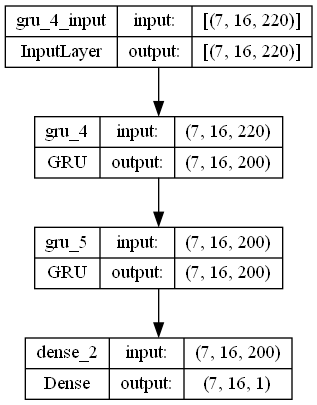

In [27]:
new_model.summary()
from keras.utils.vis_utils import plot_model
plot_model(new_model, 'model2.png', show_shapes=True, expand_nested=True)

In [35]:
# pip install onnx


  Using cached onnx-1.13.0-cp39-cp39-win_amd64.whl (12.2 MB)


## Convert to onnx

In [1]:
!pip install protobuf==3.20.2
from tensorflow import keras
import keras2onnx
import onnx

# convert to onnx
onnx_model = keras2onnx.convert_keras(new_model, new_model.name)

# Save
onnx.save_model(onnx_model, "ccf_gru_static_keras2onnx.onnx")

AttributeError: module 'tensorflow.python.keras' has no attribute 'applications'

In [47]:
!pip install tf2onnx
import tf2onnx

# convert to onnx
spec = (tf.TensorSpec((7, 16, 220), tf.float32, name="input"),)
output_path = new_model.name + ".onnx"

onnx_model = tf2onnx.convert.from_keras(new_model, spec, output_path=output_path)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


     ------------------------------------ 442.3/442.3 kB 890.8 kB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.4
    Uninstalling flatbuffers-23.1.4:
      Successfully uninstalled flatbuffers-23.1.4


In [1]:
import onnx
onnx_model = onnx.load("onnx models/ccf_gru_static_tf2onnx_OS_new.onnx")